# Look at paths that were within DrugMechDB

Here we will look at the DrugMechDB paths contained within the network, and compare them to the actual paths selected by the model.

In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '13_Final_Model_Training'

nw_dir = load_dir.joinpath('10_Semmantic_Compression', 'out')
hyp_dir = load_dir.joinpath('11c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')

In [3]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [4]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [5]:
from hetnet_ml.extractor import MatrixFormattedGraph
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 96/96 [02:03<00:00,  1.28s/it]



Determining degrees for each node and metaedge


100%|██████████| 96/96 [00:30<00:00,  3.13it/s]



Weighting matrices by degree with dampening factor 0.5267957740707717...


100%|██████████| 96/96 [00:02<00:00, 40.86it/s]


In [6]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
metapaths = pd.read_csv(hyp_dir.joinpath('kept_features.txt'), header=None)[0].tolist()

In [8]:
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
metagraph = dataframes_to_metagraph(nodes, edges)

all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

In [9]:
res = pd.read_csv(model_dir.joinpath('results.csv'))
coef = pd.read_csv(model_dir.joinpath('coef.csv'))
len(res)

85126262

In [10]:
id_to_name = nodes.set_index('id')['name'].to_dict()
res['chem_name'] = res['chemicalsubstance_id'].map(id_to_name)
res['dis_name'] = res['disease_id'].map(id_to_name)
res = res.sort_values('proba', ascending=False).reset_index(drop=True)

res.head(2)

chemicalsubstance_id    disease_id  status     proba  \
0          CHEBI:87690  DOID:0060224       0  0.998078   
1          CHEBI:27300    DOID:10609       1  0.997832   

                                           chem_name             dis_name  
0  N-(2,6-dimethylphenyl)-2-\{4-[2-hydroxy-3-(2-m...  atrial fibrillation  
1                                          vitamin D              rickets

In [11]:
def find_nodes_by_name(sub_str, n_type=None):
    if n_type is not None:
        qr = nodes.query('label == @n_type')   
    else:
        qr = nodes
    
    return qr[qr['name'].str.contains(sub_str)]

In [12]:
pos_coef = coef.query('coef > 0')['feature'].tolist()

In [13]:
msat = model[0]
max_abs = model[1]

In [14]:
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

In [15]:
def get_model_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [16]:
def get_std_model_metric(path_df):
    
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [17]:
def get_scal_dwpc_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    dwpc_metric = scal_metric * percent_of_total
    return dwpc_metric

In [18]:
def get_path_info(compound, disease, n_jobs=30, mps=None):
    if mps == None:
        mps = pos_coef
    
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, mps, n_jobs=n_jobs))
    path_df['model_metric'] = get_model_metric(path_df)
    path_df['std_metric'] = get_std_model_metric(path_df)
    path_df['scal_metric'] = get_scal_dwpc_metric(path_df)
    
    return path_df

## Load in the DrugMechDB Paths

In [19]:
dmdb_paths = pd.read_csv('paths_in_nw.csv')

chem_ids = []
dis_ids = []
path_pairs = []

for row in dmdb_paths.itertuples(index=False):
    chem_ids.append(row[0])
    prev = row[0]
    for n in row:
        if pd.isnull(n):
            break
        prev = n
    dis_ids.append(prev)
    path_pairs.append((row[0], prev))

In [20]:
chem_to_extract = list(set(chem_ids))

In [21]:
# Some "Diseases" may be phenotypes, so we should enforce diseaes for extraction
dis_to_extract = list(set(nodes.query('label == "Disease"')['id']) & set(dis_ids))

In [22]:
(dmdb_pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=metapaths, start_nodes=chem_to_extract, 
                                        end_nodes=dis_to_extract, n_jobs=30, return_sparse=True, sparse_df=False)

Preparing function arguments...
Calculating DWPCs...


100%|██████████| 196/196 [02:54<00:00,  1.12it/s]



Reshaping Result Matrices...


100%|██████████| 196/196 [00:00<00:00, 1048.61it/s]


Stacking columns...


In [23]:
dmdb_pairs['proba'] = model.predict_proba(dwpc)[:, 1]

In [24]:
dmdb_pairs['chem_name'] = dmdb_pairs['chemicalsubstance_id'].map(id_to_name)
dmdb_pairs['dis_name'] = dmdb_pairs['disease_id'].map(id_to_name)

In [25]:
pos_tups = set(edges.query('type == "treats_CtD"')[['start_id', 'end_id']].apply(tuple, axis=1))

In [26]:
status = []
for row in dmdb_pairs.itertuples():
    tup = (row.chemicalsubstance_id, row.disease_id)
    status.append(int(bool(pos_tups & {tup})))

In [27]:
dmdb_pairs['status'] = status
dmdb_pairs.sample(10)

chemicalsubstance_id    disease_id     proba  \
90           CHEBI:31690    DOID:60080  0.090796   
176          CHEBI:64354    DOID:10763  0.468976   
183          CHEBI:64354    DOID:50671  0.027679   
97           CHEBI:32193     DOID:1307  0.036658   
163          CHEBI:58987     DOID:1875  0.617938   
208          CHEBI:77733    DOID:10763  0.864667   
197          CHEBI:75725      DOID:349  0.002165   
239          CHEBI:82162  MESH:D001943  0.036942   
40           CHEBI:13719    DOID:60075  0.041258   
119          CHEBI:36797    DOID:50671  0.041292   

                                             chem_name  \
90                           imatinib methanesulfonate   
176                                         metolazone   
183                                         metolazone   
97                                           Terguride   
163                                 sildenafil citrate   
208  2-(3,4-dimethoxyphenyl)-5-\{[2-(3,4-dimethoxyp...   
197                                     (R,R)-tramadol   
239                                           Tetrasul   
40                                    acetylsalicylate   
119                                     (R)-duloxetine   

                                              dis_name  status  
90   Advanced hormone receptor-positive, HER2­ nega...       0  
176                                       hypertension       1  
183  Breast cancer in postmenopausal women with ost...       0  
97                                            dementia       0  
163                               erectile dysfunction       1  
208                                       hypertension       1  
197                              systemic mastocytosis       0  
239                                    breast neoplasm       0  
40      Estrogen-receptor positive early breast cancer       0  
119  Breast cancer in postmenopausal women with ost...       0

In [28]:
this_name = '14b_Model_results_analysis_DMDB'
out_dir = load_dir.joinpath(this_name, 'out')

out_dir.mkdir(exist_ok=True, parents=True)

dmdb_pairs.to_csv(out_dir.joinpath('dmdb_probas.csv'), index=False)

In [29]:
dmdb_pairs = dmdb_pairs.sort_values('proba', ascending=False)

In [30]:
dmdb_pairs['tup'] = dmdb_pairs[['chemicalsubstance_id', 'disease_id']].apply(tuple, axis=1)

In [31]:
dmdb_pairs.query('tup in @path_pairs')

chemicalsubstance_id    disease_id     proba  \
109          CHEBI:32193     DOID:6432  0.951020   
94           CHEBI:31690     DOID:8552  0.660270   
163          CHEBI:58987     DOID:1875  0.617938   
59           CHEBI:29081    DOID:60164  0.609747   
68           CHEBI:31583     DOID:2030  0.547551   
203          CHEBI:75725    DOID:60164  0.502799   
176          CHEBI:64354    DOID:10763  0.468976   
143          CHEBI:53790  MESH:D001943  0.390487   
43           CHEBI:13719    DOID:60164  0.257871   
85           CHEBI:31690      DOID:349  0.186107   
135          CHEBI:53790    DOID:50671  0.158693   
114          CHEBI:36797     DOID:1470  0.148096   
137          CHEBI:53790    DOID:60076  0.114064   
136          CHEBI:53790    DOID:60075  0.113618   
138          CHEBI:53790    DOID:60080  0.113328   
12          CHEBI:135809    DOID:60224  0.053763   
18          CHEBI:135990     DOID:1470  0.048684   
209          CHEBI:77733     DOID:1307  0.033739   
150           CHEBI:5439    DOID:50433  0.023906   

                                             chem_name  \
109                                          Terguride   
94                           imatinib methanesulfonate   
163                                 sildenafil citrate   
59                                          synephrine   
68                                            Etizolam   
203                                     (R,R)-tramadol   
176                                         metolazone   
143                              (S)-aminoglutethimide   
43                                    acetylsalicylate   
85                           imatinib methanesulfonate   
135                              (S)-aminoglutethimide   
114                                     (R)-duloxetine   
137                              (S)-aminoglutethimide   
136                              (S)-aminoglutethimide   
138                              (S)-aminoglutethimide   
12                                           landiolol   
18                                            gepirone   
209  2-(3,4-dimethoxyphenyl)-5-\{[2-(3,4-dimethoxyp...   
150                                       Glutethimide   

                                              dis_name  status  \
109                             pulmonary hypertension       0   
94                            chronic myeloid leukemia       1   
163                               erectile dysfunction       1   
59                                         Pain relief       0   
68                                    anxiety disorder       1   
203                                        Pain relief       1   
176                                       hypertension       1   
143                                    breast neoplasm       1   
43                                         Pain relief       1   
85                               systemic mastocytosis       0   
135  Breast cancer in postmenopausal women with ost...       0   
114                          major depressive disorder       1   
137                         ER-negative breast cancers       0   
136     Estrogen-receptor positive early breast cancer       0   
138  Advanced hormone receptor-positive, HER2­ nega...       0   
12                                 Atrial fibrillation       0   
18                           major depressive disorder       1   
209                                           dementia       0   
150                                           Insomnia       0   

                             tup  
109     (CHEBI:32193, DOID:6432)  
94      (CHEBI:31690, DOID:8552)  
163     (CHEBI:58987, DOID:1875)  
59     (CHEBI:29081, DOID:60164)  
68      (CHEBI:31583, DOID:2030)  
203    (CHEBI:75725, DOID:60164)  
176    (CHEBI:64354, DOID:10763)  
143  (CHEBI:53790, MESH:D001943)  
43     (CHEBI:13719, DOID:60164)  
85       (CHEBI:31690, DOID:349)  
135    (CHEBI:53790, DOID:50671)  
114     (CHEBI:36797, DOID:1470)  
137    (CHEBI:53790, DOID:

In [32]:
def get_pair_idx(idx, df):

    cid = df.loc[idx, 'chemicalsubstance_id']
    did = df.loc[idx, 'disease_id']
    prob = df.loc[idx, 'proba']

    print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
    try:
        path_df = get_path_info(cid, did, 30)
    except:
        path_df = get_path_info(cid, did, 1)
    return path_df.sort_values('model_metric', ascending=False).reset_index(drop=True)

In [33]:
from tqdm import tqdm

## Extract all paths for indications in DrugMechDB

In [34]:
dmdb_res = dmdb_pairs.query('tup in @path_pairs')

path_res = dict()

for f in out_dir.iterdir():
    if f.name.startswith('paths_'):
        
        test_path = pd.read_csv(f, converters={'nodes': eval, 'node_ids': eval, 'node_id_tup': eval})
        start_id = f.name.split('_')[1]
        end_id = f.name.split('_')[2].rstrip('.csv')
    
        path_res[(start_id, end_id)] = test_path

# Don't do this extraction on future runs...
if len(path_res) == 0:
    # Extract the paths
    for row in tqdm(dmdb_res.itertuples(), total=len(dmdb_res)):
        path_res[row.tup] = get_pair_idx(row.Index, dmdb_res)
        
    # Save so it never needs to be done again...
    for k, v in path_res.items():
        v.to_csv(out_dir.joinpath('paths_{0}_{1}.csv'.format(*k)), index=False)

In [35]:
from collections import defaultdict

In [36]:
def query_target(path_df, tgt_id):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[1])
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [37]:
dmdb_paths

n1             n2            n3          n4            n5
0    CHEBI:31690    NCBIGene:25    HP:0005506         NaN           NaN
1    CHEBI:31690    NCBIGene:25     DOID:8552         NaN           NaN
2    CHEBI:31690  NCBIGene:3815    GO:0008283    DOID:349           NaN
3    CHEBI:31690  NCBIGene:5156    GO:0008283    DOID:349           NaN
4    CHEBI:29081  NCBIGene:5743  MESH:D011453  DOID:60164           NaN
5    CHEBI:29081  NCBIGene:5743  MESH:D011453  HP:0012531           NaN
6    CHEBI:13719  NCBIGene:5743  MESH:D011453  DOID:60164           NaN
7    CHEBI:13719  NCBIGene:5743  MESH:D011453  HP:0012531           NaN
8    CHEBI:82162   NCBIGene:148    GO:0042310  HP:0001742           NaN
9    CHEBI:36797  NCBIGene:6532    GO:0051610   DOID:1470           NaN
10   CHEBI:58987  NCBIGene:8654   CHEBI:16356  GO:0042311     DOID:1875
11   CHEBI:58987  NCBIGene:8654   CHEBI:16356  GO:0042311    HP:0000802
12   CHEBI:32193  NCBIGene:3357     DOID:6432         NaN           NaN
13   CHEBI:32193  NCBIGene:3357    HP:0002092         NaN           NaN
14  CHEBI:135809   NCBIGene:153    GO:0045823  HP:0001649           NaN
15  CHEBI:135809   NCBIGene:153    GO:0045823  DOID:60224           NaN
16   CHEBI:64354  NCBIGene:6559    GO:0055078  DOID:10763           NaN
17   CHEBI:64354  NCBIGene:6559    GO:0055078  HP:0000822           NaN
18  CHEBI:135990  NCBIGene:3350    GO:0050795   DOID:1470           NaN
19   CHEBI:75725  NCBIGene:4988    GO:0019233  DOID:60164           NaN
20   CHEBI:75725  NCBIGene:4988    GO:0019233  HP:0012531           NaN
21   CHEBI:53790  NCBIGene:1588  MESH:D004967  GO:0008283    HP:0003002
22   CHEBI:53790  NCBIGene:1588  MESH:D004967  GO:0008283    DOID:60075
23   CHEBI:53790  NCBIGene:1588  MESH:D004967  GO:0008283    DOID:60076
24   CHEBI:53790  NCBIGene:1588  MESH:D004967  GO:0008283    DOID:50671
25   CHEBI:53790  NCBIGene:1588  MESH:D004967  GO:0008283    DOID:60080
26   CHEBI:53790  NCBIGene:1588  MESH:D004967  GO:0008283  MESH:D001943
27   CHEBI:31583  NCBIGene:2554    GO:0022851   DOID:2030           NaN
28   CHEBI:77733  NCBIGene:5136    GO:0043025   DOID:1307           NaN
29   CHEBI:77733  NCBIGene:5136    GO:0043025  HP:0000726           NaN
30    CHEBI:5439  NCBIGene:2554    GO:1904862  DOID:50433           NaN
31    CHEBI:5439  NCBIGene:2554    GO:1904862  HP:0100785           NaN

## Summarize the findings from DMDB

In [38]:
summary_info = defaultdict(list)

for i, pair in enumerate(path_pairs):
    
    if pair not in path_res.keys():
        continue
        
    this_res = path_res[pair]
    
    info = dmdb_res.query('tup == @pair')
    
    this_chem = info.iloc[0]['chem_name']
    this_dis = info.iloc[0]['dis_name']
    this_prob = info.iloc[0]['proba']
    
    path_tup = tuple(dmdb_paths.loc[i].dropna())
    
    #make queryable by conveting to tuple
    this_res['node_id_tup'] = this_res['node_ids'].apply(tuple)
    
    # get the results that have the desired target
    tgt_res = query_target(this_res, path_tup[1])
    tgt_res = tgt_res.reset_index().rename(columns={'index': 'old_idx'})
    
    found = this_res.query('node_id_tup == @path_tup')
    
    if len(found) == 0:
        summary_info['chem_name'].append(this_chem)
        summary_info['dis_name'].append(this_dis)
        summary_info['chem_id'].append(path_tup[0])
        summary_info['dis_id'].append(path_tup[-1])
        summary_info['treat_prob'].append(this_prob)
        summary_info['model_metric'].append(float('nan'))
        summary_info['metapath'].append(float('nan'))
        summary_info['overall_rank'].append(float('nan'))
        summary_info['total_paths'].append(len(this_res))
        summary_info['tgt_rank'].append(float('nan'))
        summary_info['tgt_paths'].append(len(tgt_res))
        summary_info['mp_rank'].append(float('nan'))
        summary_info['mp_paths'].append(float('nan'))

    
    for row in found.itertuples():
        mp = row.metapath
        idx = row.Index
        mp_res = this_res.query('metapath == @mp').reset_index().rename(columns={'index': 'old_idx'})
        
        summary_info['chem_name'].append(this_chem)
        summary_info['dis_name'].append(this_dis)
        summary_info['chem_id'].append(path_tup[0])
        summary_info['dis_id'].append(path_tup[-1])
        summary_info['treat_prob'].append(this_prob)
        summary_info['model_metric'].append(row.model_metric)
        summary_info['metapath'].append(row.metapath)
        summary_info['overall_rank'].append(int(row.Index)+1)
        summary_info['total_paths'].append(len(this_res))
        summary_info['tgt_rank'].append(int(tgt_res.query('old_idx == @idx').iloc[0].name)+1)
        summary_info['tgt_paths'].append(len(tgt_res))
        summary_info['mp_rank'].append(int(mp_res.query('old_idx == @idx').iloc[0].name)+1)
        summary_info['mp_paths'].append(len(mp_res))

        
summary_df = pd.DataFrame(summary_info)
summary_df

chem_name  \
0                           imatinib methanesulfonate   
1                           imatinib methanesulfonate   
2                           imatinib methanesulfonate   
3                           imatinib methanesulfonate   
4                                          synephrine   
5                                    acetylsalicylate   
6                                      (R)-duloxetine   
7                                  sildenafil citrate   
8                                           Terguride   
9                                           Terguride   
10                                          landiolol   
11                                         metolazone   
12                                           gepirone   
13                                     (R,R)-tramadol   
14                              (S)-aminoglutethimide   
15                              (S)-aminoglutethimide   
16                              (S)-aminoglutethimide   
17                              (S)-aminoglutethimide   
18                              (S)-aminoglutethimide   
19                                           Etizolam   
20  2-(3,4-dimethoxyphenyl)-5-\{[2-(3,4-dimethoxyp...   
21                                       Glutethimide   

                                             dis_name       chem_id  \
0                            chronic myeloid leukemia   CHEBI:31690   
1                            chronic myeloid leukemia   CHEBI:31690   
2                               systemic mastocytosis   CHEBI:31690   
3                               systemic mastocytosis   CHEBI:31690   
4                                         Pain relief   CHEBI:29081   
5                                         Pain relief   CHEBI:13719   
6                           major depressive disorder   CHEBI:36797   
7                                erectile dysfunction   CHEBI:58987   
8                              pulmonary hypertension   CHEBI:32193   
9                              pulmonary hypertension   CHEBI:32193   
10                                Atrial fibrillation  CHEBI:135809   
11                                       hypertension   CHEBI:64354   
12                          major depressive disorder  CHEBI:135990   
13                                        Pain relief   CHEBI:75725   
14     Estrogen-receptor positive early breast cancer   CHEBI:53790   
15                         ER-negative breast cancers   CHEBI:53790   
16  Breast cancer in postmenopausal women with ost...   CHEBI:53790   
17  Advanced hormone receptor-positive, HER2­ nega...   CHEBI:53790   
18                                    breast neoplasm   CHEBI:53790   
19                                   anxiety disorder   CHEBI:31583   
20                                           dementia   CHEBI:77733   
21                                           Insomnia    CHEBI:5439   

          dis_id  treat_prob  model_metric    metapath  overall_rank  \
0      DOID:8552    0.660270      0.065088      CinGmD          39.0   
1      DOID:8552    0.660270      0.060711       CaGmD          41.0   
2       DOID:349    0.186107           NaN         NaN           NaN   
3       DOID:349    0.186107           NaN         NaN           NaN   
4     DOID:60164    0.609747           NaN         NaN           NaN   
5     DOID:60164    0.257871           NaN         NaN           NaN   
6      DOID:1470    0.148096      0.004214  CinGiBPawD         383.0   
7      DOID:1875    0.617938           NaN         NaN           NaN   
8      DOID:6432    0.951020      0.258229      CinGmD           4.0   
9      DOID:6432    0.951020      0.215978       CaGmD           6.0   
10    DOID:60224    0.053763      0.034457  CinGiBPawD          16.0   
11    DOID:10763    0.468976      0.019932  CinGiBPawD          57.0   
12     DOID:1470    0.048684      0.022682   CaGiBPawD          30.0   
13    DOID:60164    0.502799      0.000116   CaGiBPawD       11399.0   
14    DOID:60075  

In [39]:
summary_df.to_csv(out_dir.joinpath('summary_data.csv'), index=False)

## Plot some of the results

In [40]:
import networkx as nx
from collections import defaultdict

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

default_colors = sns.color_palette()

In [41]:
import warnings
warnings.simplefilter('ignore')

In [42]:
edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

In [43]:
id_to_label = nodes.set_index('id')['label'].to_dict()

In [44]:
node_color_map = {'AnatomicalEntity': '#5252b9',
                'BiologicalProcessOrActivity': '#fc99d5',
                'MacromolecularMachine': '#d032a3',
                'Disease': '#50e316',
                'Pathway': '#b7d165',
                'PhenotypicFeature': '#165f28',
                'GeneFamily': '#6404b7',
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': '#e9bf98',
                'ChemicalSubstance': '#21f0b6',}

In [45]:
test_paths = path_res[('CHEBI:32193', 'DOID:6432')]

In [46]:
summary_df['model_pct'] = 1- (summary_df['overall_rank'] / summary_df['total_paths'])
summary_df['tgt_pct'] = 1- (summary_df['tgt_rank'] / summary_df['tgt_paths'])
summary_df['mp_pct'] = 1- (summary_df['mp_rank'] / summary_df['mp_paths'])

In [47]:
summary_df['ind_name'] = summary_df['chem_name'] + '\n' + summary_df['dis_name']
plt_df = summary_df.dropna(subset=['metapath']).sort_values('model_pct', ascending=False).drop_duplicates(subset=['ind_name'])

In [48]:
plt_df

chem_name                   dis_name       chem_id  \
0   imatinib methanesulfonate   chronic myeloid leukemia   CHEBI:31690   
8                   Terguride     pulmonary hypertension   CHEBI:32193   
21               Glutethimide                   Insomnia    CHEBI:5439   
11                 metolazone               hypertension   CHEBI:64354   
19                   Etizolam           anxiety disorder   CHEBI:31583   
12                   gepirone  major depressive disorder  CHEBI:135990   
6              (R)-duloxetine  major depressive disorder   CHEBI:36797   
13             (R,R)-tramadol                Pain relief   CHEBI:75725   
10                  landiolol        Atrial fibrillation  CHEBI:135809   

        dis_id  treat_prob  model_metric    metapath  overall_rank  \
0    DOID:8552    0.660270      0.065088      CinGmD          39.0   
8    DOID:6432    0.951020      0.258229      CinGmD           4.0   
21  DOID:50433    0.023906      0.009303   CaGiBPawD          70.0   
11  DOID:10763    0.468976      0.019932  CinGiBPawD          57.0   
19   DOID:2030    0.547551      0.015623   CaGeBPawD         157.0   
12   DOID:1470    0.048684      0.022682   CaGiBPawD          30.0   
6    DOID:1470    0.148096      0.004214  CinGiBPawD         383.0   
13  DOID:60164    0.502799      0.000116   CaGiBPawD       11399.0   
10  DOID:60224    0.053763      0.034457  CinGiBPawD          16.0   

    total_paths  tgt_rank  tgt_paths  mp_rank  mp_paths  model_pct   tgt_pct  \
0       3464791       3.0      20637      3.0       3.0   0.999989  0.999855   
8        251943       1.0        610      1.0       1.0   0.999984  0.998361   
21       309589       2.0       5406      2.0     238.0   0.999774  0.999630   
11       119927      31.0        457      3.0      12.0   0.999525  0.932166   
19       221796      25.0      29072      8.0      31.0   0.999292  0.999140   
12        31922      21.0       2566      2.0      14.0   0.999060  0.991816   
6        252059      31.0         94     18.0     185.0   0.998481  0.670213   
13      1310797     219.0       2009    388.0     762.0   0.991304  0.890991   
10         1381      15.0        246      2.0      16.0   0.988414  0.939024   

      mp_pct                                           ind_name  
0   0.000000  imatinib methanesulfonate\nchronic myeloid leu...  
8   0.000000                  Terguride\npulmonary hypertension  
21  0.991597                             Glutethimide\nInsomnia  
11  0.750000                           metolazone\nhypertension  
19  0.741935                         Etizolam\nanxiety disorder  
12  0.857143                gepirone\nmajor depressive disorder  
6   0.902703          (R)-duloxetine\nmajor depressive disorder  
13  0.490814                        (R,R)-tramadol\nPain relief  
10  0.875000                     landiolol\nAtrial fibrillation

In [49]:
plt_df['ind_tup'] = plt_df[['chem_id', 'dis_id']].apply(tuple, axis=1)

In [50]:
ind_to_tgt_map = {}
for i in range(len(dmdb_paths)):
    path_tup = tuple(dmdb_paths.loc[i].dropna())
    ind_to_tgt_map[(path_tup[0], path_tup[-1])] = path_tup[1]

In [51]:
plt_df['tgt'] = plt_df['ind_tup'].map(ind_to_tgt_map).map(id_to_name)

In [52]:
plt_df[['chem_name', 'dis_name',  'total_paths', 'overall_rank', 'model_pct', 'tgt', 'tgt_paths', 'tgt_rank', 'tgt_pct', 'metapath', 'mp_paths', 'mp_rank', 'mp_pct']]

chem_name                   dis_name  total_paths  \
0   imatinib methanesulfonate   chronic myeloid leukemia      3464791   
8                   Terguride     pulmonary hypertension       251943   
21               Glutethimide                   Insomnia       309589   
11                 metolazone               hypertension       119927   
19                   Etizolam           anxiety disorder       221796   
12                   gepirone  major depressive disorder        31922   
6              (R)-duloxetine  major depressive disorder       252059   
13             (R,R)-tramadol                Pain relief      1310797   
10                  landiolol        Atrial fibrillation         1381   

    overall_rank  model_pct      tgt  tgt_paths  tgt_rank   tgt_pct  \
0           39.0   0.999989     ABL1      20637       3.0  0.999855   
8            4.0   0.999984    HTR2B        610       1.0  0.998361   
21          70.0   0.999774   GABRA1       5406       2.0  0.999630   
11          57.0   0.999525  SLC12A3        457      31.0  0.932166   
19         157.0   0.999292   GABRA1      29072      25.0  0.999140   
12          30.0   0.999060    HTR1A       2566      21.0  0.991816   
6          383.0   0.998481   SLC6A4         94      31.0  0.670213   
13       11399.0   0.991304    OPRM1       2009     219.0  0.890991   
10          16.0   0.988414    ADRB1        246      15.0  0.939024   

      metapath  mp_paths  mp_rank    mp_pct  
0       CinGmD       3.0      3.0  0.000000  
8       CinGmD       1.0      1.0  0.000000  
21   CaGiBPawD     238.0      2.0  0.991597  
11  CinGiBPawD      12.0      3.0  0.750000  
19   CaGeBPawD      31.0      8.0  0.741935  
12   CaGiBPawD      14.0      2.0  0.857143  
6   CinGiBPawD     185.0     18.0  0.902703  
13   CaGiBPawD     762.0    388.0  0.490814  
10  CinGiBPawD      16.0      2.0  0.875000

In [53]:
colors = ["#21f0b6", "#ec102f",  "#6404b7", "#fc99d5", "#50e316", "#d032a3", "#165f28",  "#b7d165","#e9bf98", "#5252b9"]
sns.set_palette(colors)

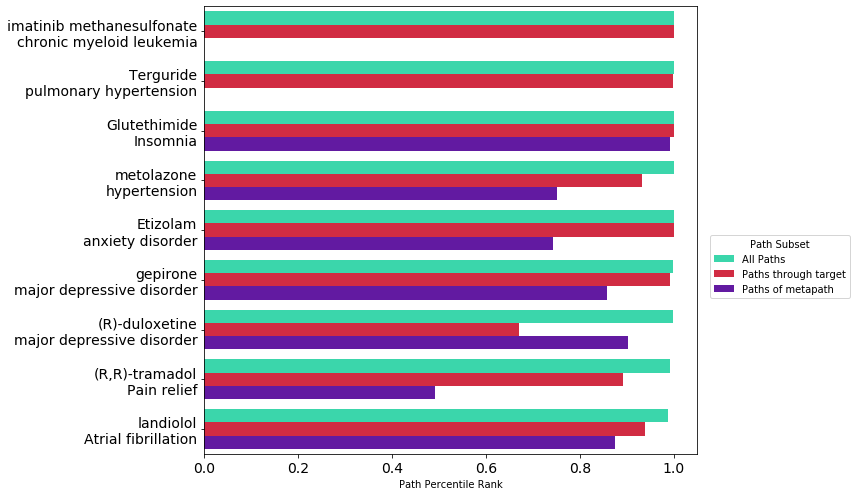

In [54]:
melt_plt_df = plt_df.melt(id_vars=['ind_name'], value_vars=['model_pct', 'tgt_pct', 'mp_pct'])

fig = plt.figure(figsize=(12, 7))
fig.set_tight_layout(True)
ax = sns.barplot(x='value', y='ind_name', hue='variable', data=melt_plt_df)

plt.ylabel('')
plt.xlabel('Path Percentile Rank')
plt.xticks(size=14)
plt.yticks(size=14)


h, l = ax.get_legend_handles_labels()
labels = ['All Paths', 'Paths through target', 'Paths of metapath']
ax.legend(h, labels, title="Path Subset", bbox_to_anchor=(1.015, .5));



In [55]:
new_plt_df = summary_df.dropna(subset=['metapath']).sort_values('model_pct', ascending=False).drop_duplicates(subset=['ind_name'])
new_melt_df = new_plt_df.melt(id_vars=['ind_name'], value_vars=['total_paths', 'tgt_paths', 'mp_paths'])


new_melt_df

ind_name     variable      value
0   imatinib methanesulfonate\nchronic myeloid leu...  total_paths  3464791.0
1                   Terguride\npulmonary hypertension  total_paths   251943.0
2                              Glutethimide\nInsomnia  total_paths   309589.0
3                            metolazone\nhypertension  total_paths   119927.0
4                          Etizolam\nanxiety disorder  total_paths   221796.0
5                 gepirone\nmajor depressive disorder  total_paths    31922.0
6           (R)-duloxetine\nmajor depressive disorder  total_paths   252059.0
7                         (R,R)-tramadol\nPain relief  total_paths  1310797.0
8                      landiolol\nAtrial fibrillation  total_paths     1381.0
9   imatinib methanesulfonate\nchronic myeloid leu...    tgt_paths    20637.0
10                  Terguride\npulmonary hypertension    tgt_paths      610.0
11                             Glutethimide\nInsomnia    tgt_paths     5406.0
12                           metolazone\nhypertension    tgt_paths      457.0
13                         Etizolam\nanxiety disorder    tgt_paths    29072.0
14                gepirone\nmajor depressive disorder    tgt_paths     2566.0
15          (R)-duloxetine\nmajor depressive disorder    tgt_paths       94.0
16                        (R,R)-tramadol\nPain relief    tgt_paths     2009.0
17                     landiolol\nAtrial fibrillation    tgt_paths      246.0
18  imatinib methanesulfonate\nchronic myeloid leu...     mp_paths        3.0
19                  Terguride\npulmonary hypertension     mp_paths        1.0
20                             Glutethimide\nInsomnia     mp_paths      238.0
21                           metolazone\nhypertension     mp_paths       12.0
22                         Etizolam\nanxiety disorder     mp_paths       31.0
23                gepirone\nmajor depressive disorder     mp_paths       14.0
24          (R)-duloxetine\nmajor depressive disorder     mp_paths      185.0
25                        (R,R)-tramadol\nPain relief     mp_paths      762.0
26                     landiolol\nAtrial fibrillation     mp_paths       16.0

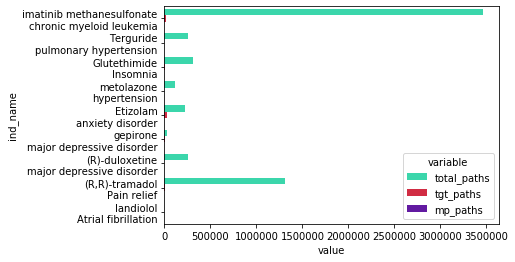

In [56]:
ax = sns.barplot(x='value', y='ind_name', hue='variable', data=new_melt_df)

In [57]:
# Choose custom node colors
node_color_map = {'AnatomicalEntity': '#5252b9',
                'BiologicalProcessOrActivity': '#fc99d5',
                'MacromolecularMachine': '#d032a3',
                'Disease': '#50e316',
                'Pathway': '#b7d165',
                'PhenotypicFeature': '#165f28',
                'GeneFamily': '#6404b7',
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': '#e9bf98',
                'ChemicalSubstance': '#21f0b6'}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()

import graph_plots as gp

def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):


    if poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
    else:
        path_of_interest = []
        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))

    edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, proba=proba, n_paths=len(list_of_paths));

## And plot the paths themselves

In [58]:
sns.set_palette(default_colors)

In [59]:
poi = path_res[('CHEBI:135990', 'DOID:1470')].loc[37, 'nodes']

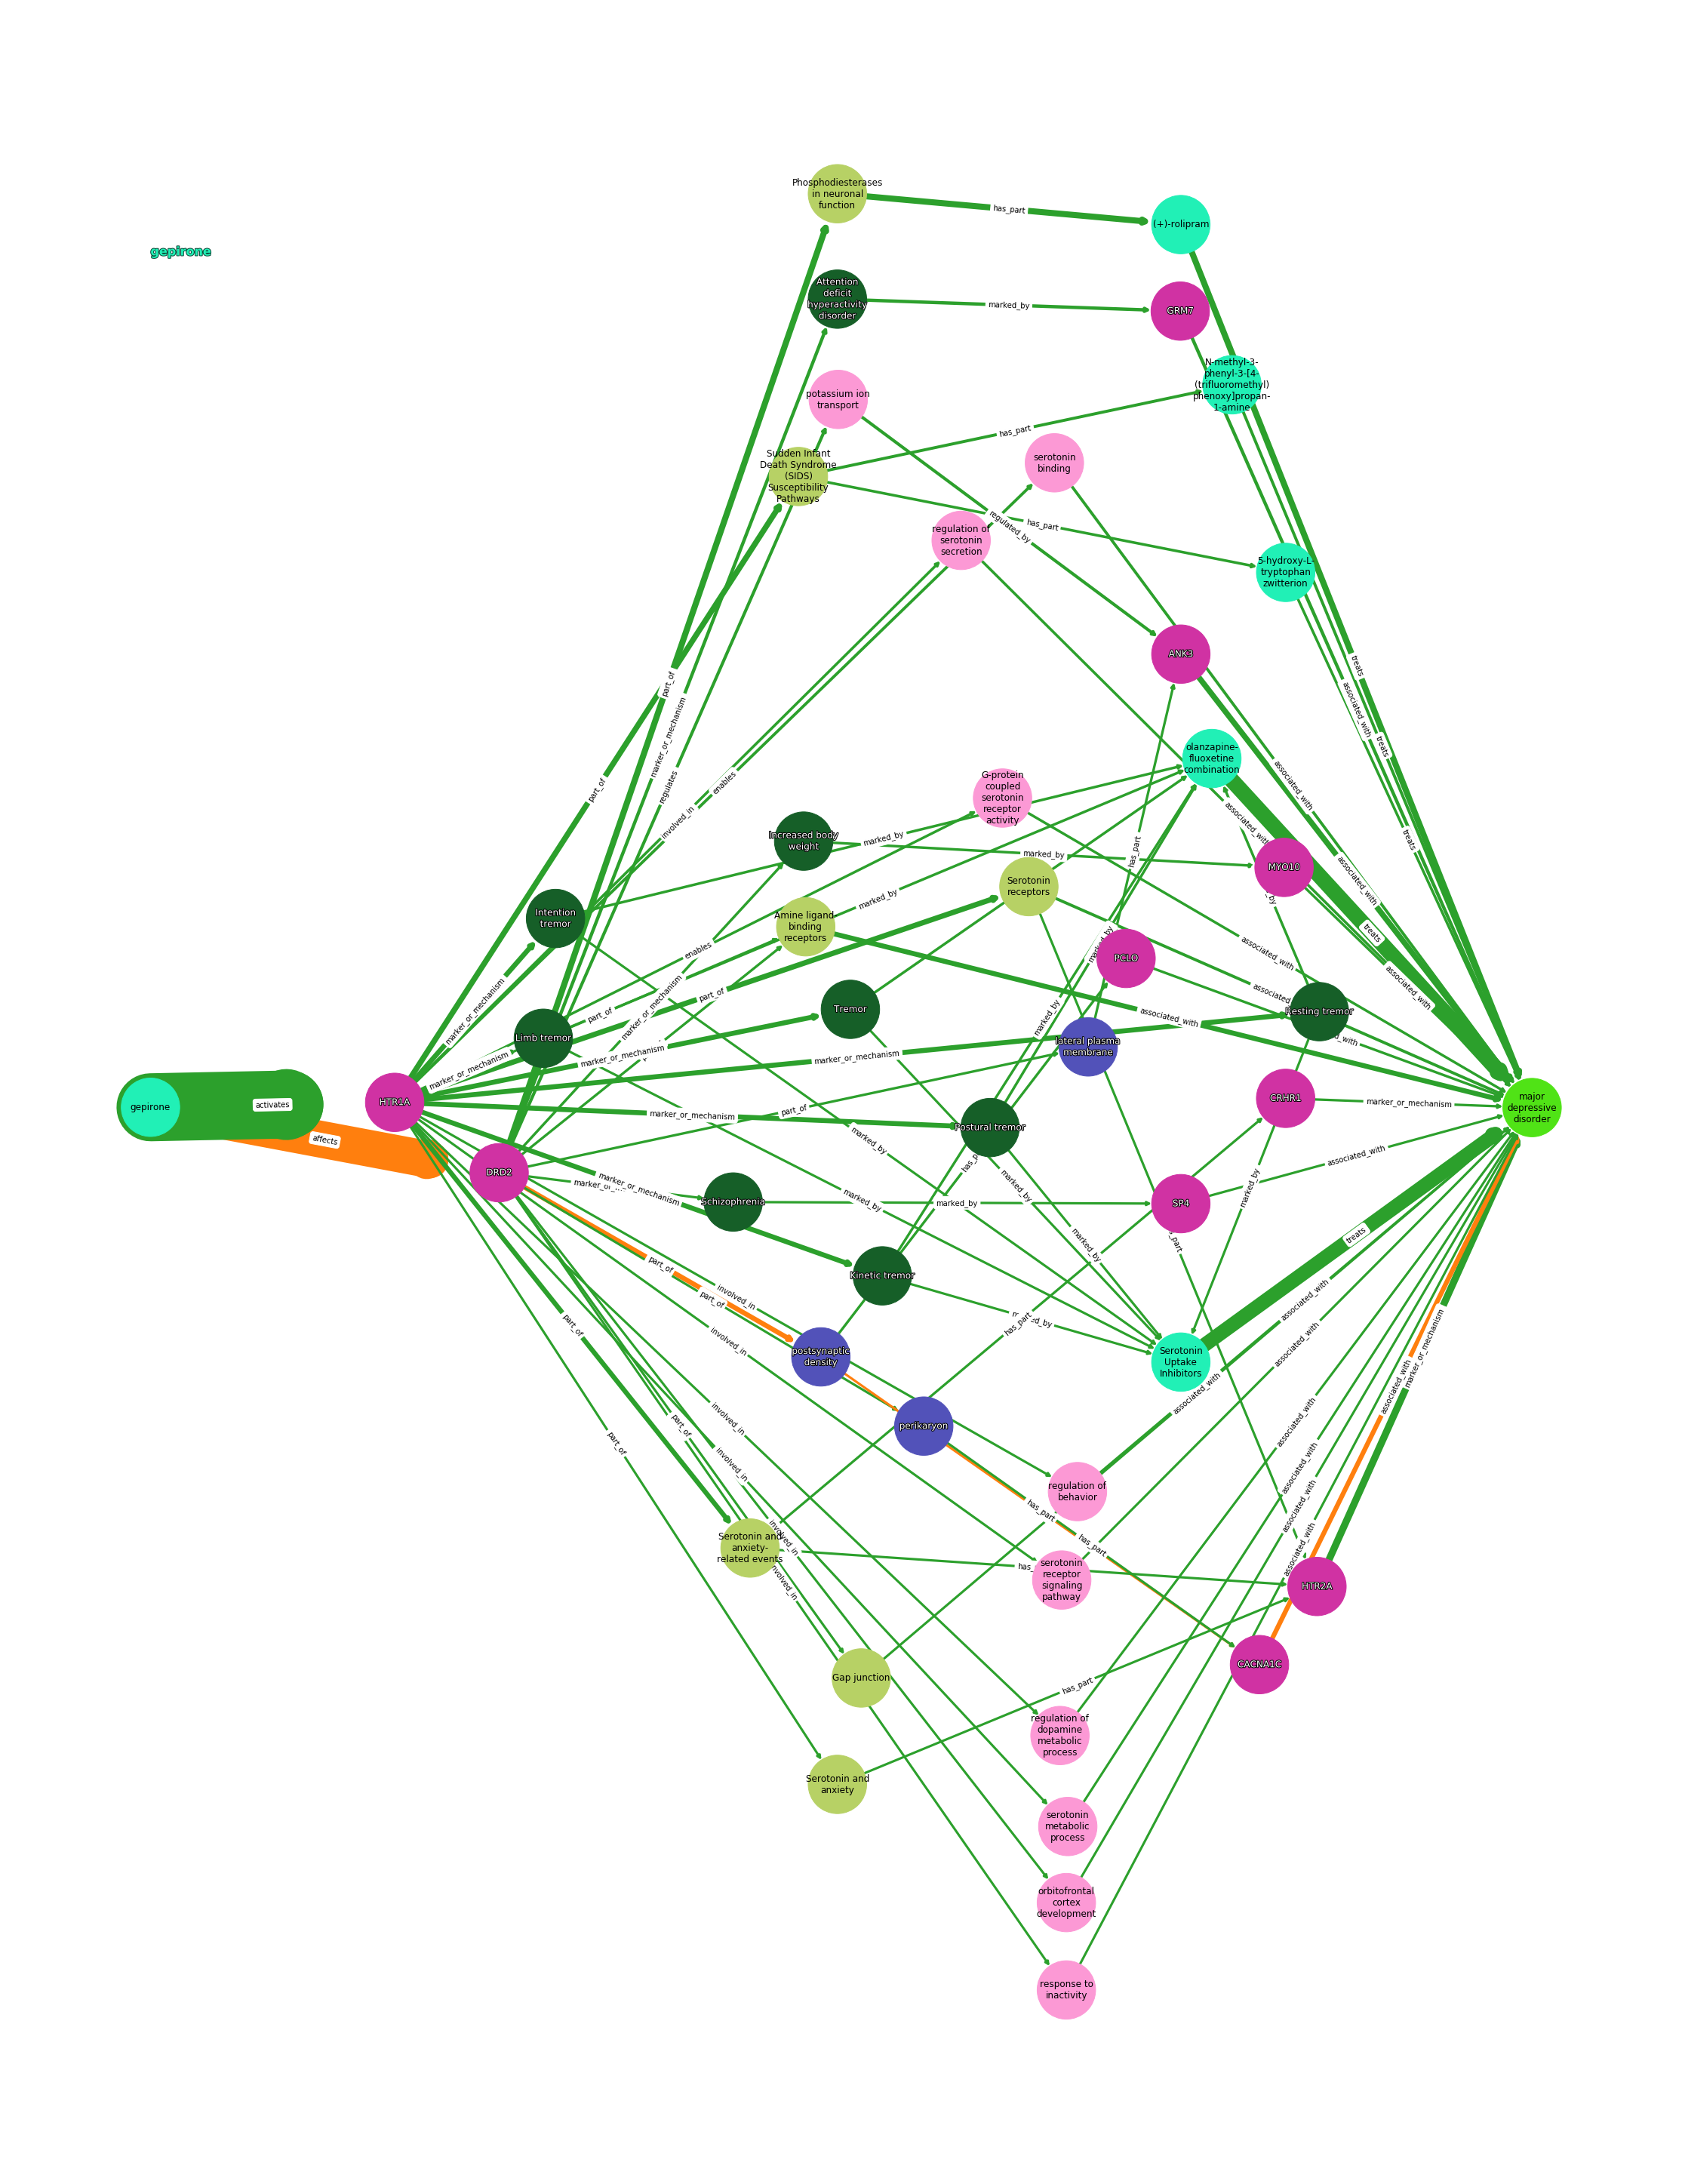

In [60]:
draw_top_paths(path_res[('CHEBI:135990', 'DOID:1470')], 40, poi_idx=37)

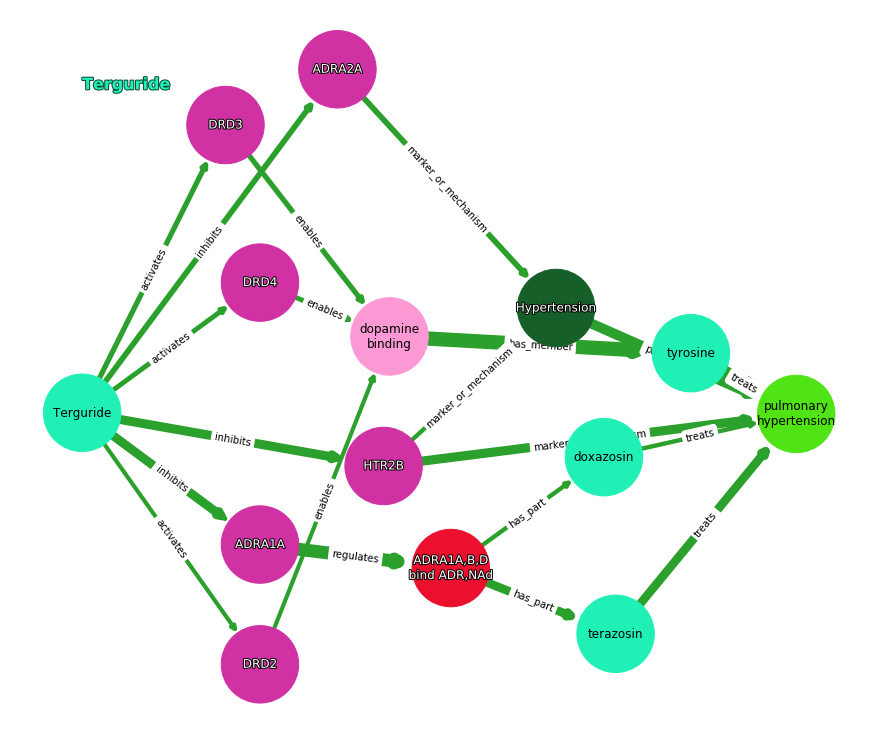

In [61]:
draw_top_paths(path_res[('CHEBI:32193', 'DOID:6432')], 10)

In [62]:
def graph_overall_pair(pair_num, n_paths=10):

    sub_sum_df = summary_df.dropna(subset=['overall_rank'])
    
    cid = sub_sum_df.iloc[pair_num].loc['chem_id']
    did = sub_sum_df.iloc[pair_num].loc['dis_id']

    this_path = path_res[(cid, did)]
    path_idx = sub_sum_df.iloc[pair_num].loc['overall_rank'].astype(int)-1
    
    prob = dmdb_pairs.query('chemicalsubstance_id == @cid and disease_id == @did')['proba'].values[0]
    draw_top_paths(this_path, n_paths, poi_idx=path_idx, proba=prob)


In [63]:
summary_df.head(2)

chem_name                  dis_name      chem_id  \
0  imatinib methanesulfonate  chronic myeloid leukemia  CHEBI:31690   
1  imatinib methanesulfonate  chronic myeloid leukemia  CHEBI:31690   

      dis_id  treat_prob  model_metric metapath  overall_rank  total_paths  \
0  DOID:8552     0.66027      0.065088   CinGmD          39.0      3464791   
1  DOID:8552     0.66027      0.060711    CaGmD          41.0      3464791   

   tgt_rank  tgt_paths  mp_rank  mp_paths  model_pct   tgt_pct    mp_pct  \
0       3.0      20637      3.0       3.0   0.999989  0.999855  0.000000   
1       4.0      20637      2.0       3.0   0.999988  0.999806  0.333333   

                                            ind_name  
0  imatinib methanesulfonate\nchronic myeloid leu...  
1  imatinib methanesulfonate\nchronic myeloid leu...

In [64]:
def graph_mp_pair(pair_num, n_paths=10):

    sub_sum_df = summary_df.dropna(subset=['overall_rank'])
    
    cid = sub_sum_df.iloc[pair_num].loc['chem_id']
    did = sub_sum_df.iloc[pair_num].loc['dis_id']
    path_idx = sub_sum_df.iloc[pair_num].loc['overall_rank'].astype(int)-1

    this_path = path_res[(cid, did)]
    poi = this_path.loc[path_idx, 'nodes']
    
    this_path['nt'] = this_path['nodes'].apply(tuple)
    poi_t = tuple(poi)
    
    mps = this_path.query('nt == @poi_t')['metapath'].unique()
    mp_path = this_path.query('metapath in @mps')
    
    prob = dmdb_pairs.query('chemicalsubstance_id == @cid and disease_id == @did')['proba'].values[0]
    draw_top_paths(mp_path, n_paths, poi_idx=path_idx, proba=prob)


In [65]:
def graph_tgt_pair(pair_num, n_paths=10):

    sub_sum_df = summary_df.dropna(subset=['overall_rank'])
    
    cid = sub_sum_df.iloc[pair_num].loc['chem_id']
    did = sub_sum_df.iloc[pair_num].loc['dis_id']
    path_idx = sub_sum_df.iloc[pair_num].loc['overall_rank'].astype(int)-1

    this_path = path_res[(cid, did)]
    poi = this_path.loc[path_idx, 'nodes']

    tgt = this_path.loc[path_idx, 'node_ids'][1]
    tgt_df = query_target(this_path, tgt)
    
    prob = dmdb_pairs.query('chemicalsubstance_id == @cid and disease_id == @did')['proba'].values[0]
    draw_top_paths(tgt_df, n_paths, poi_idx=path_idx, proba=prob)


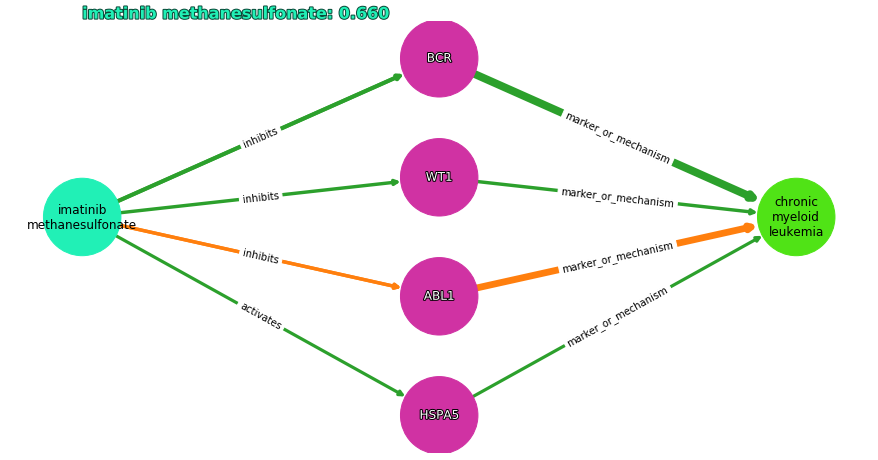

In [66]:
graph_mp_pair(0, 20)

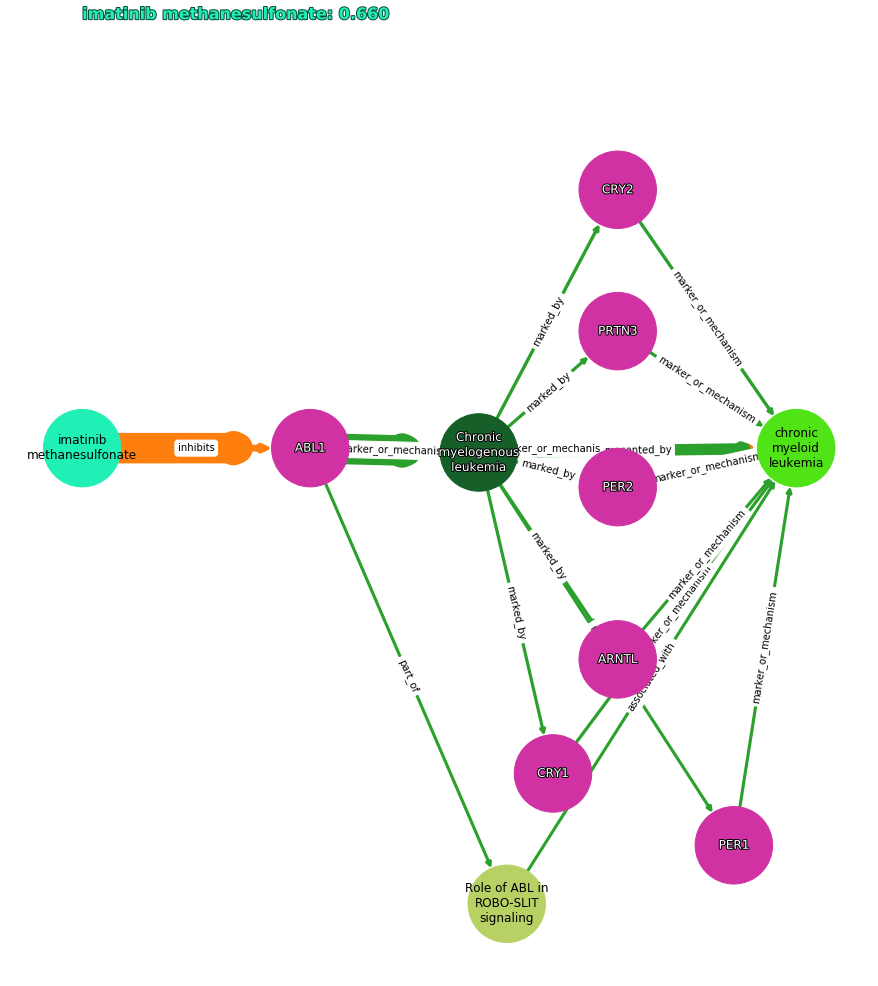

In [67]:
graph_tgt_pair(0, 12)

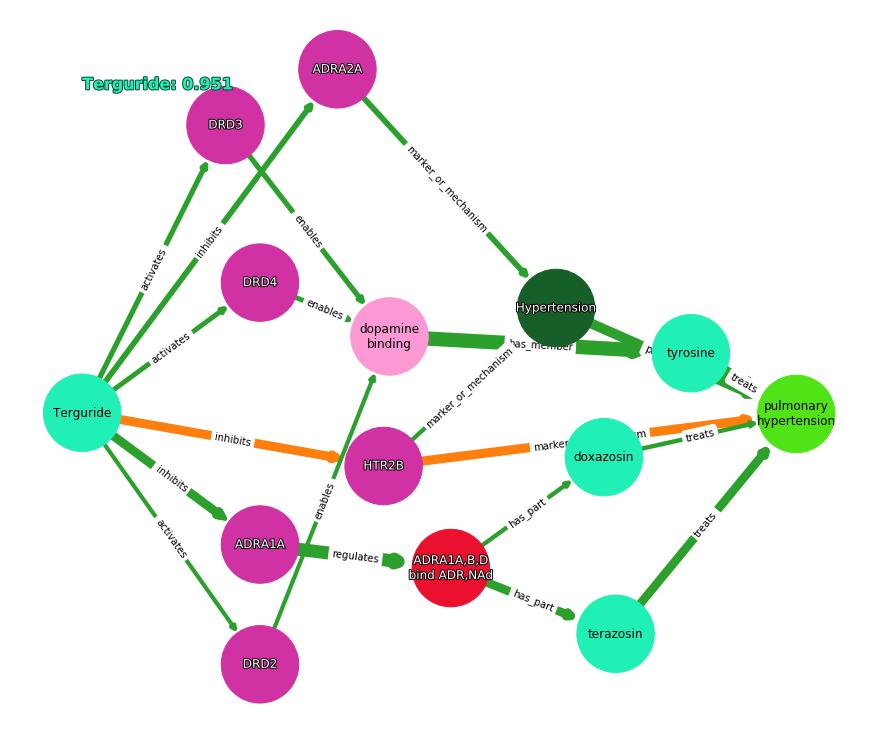

In [68]:
graph_overall_pair(3, 10)

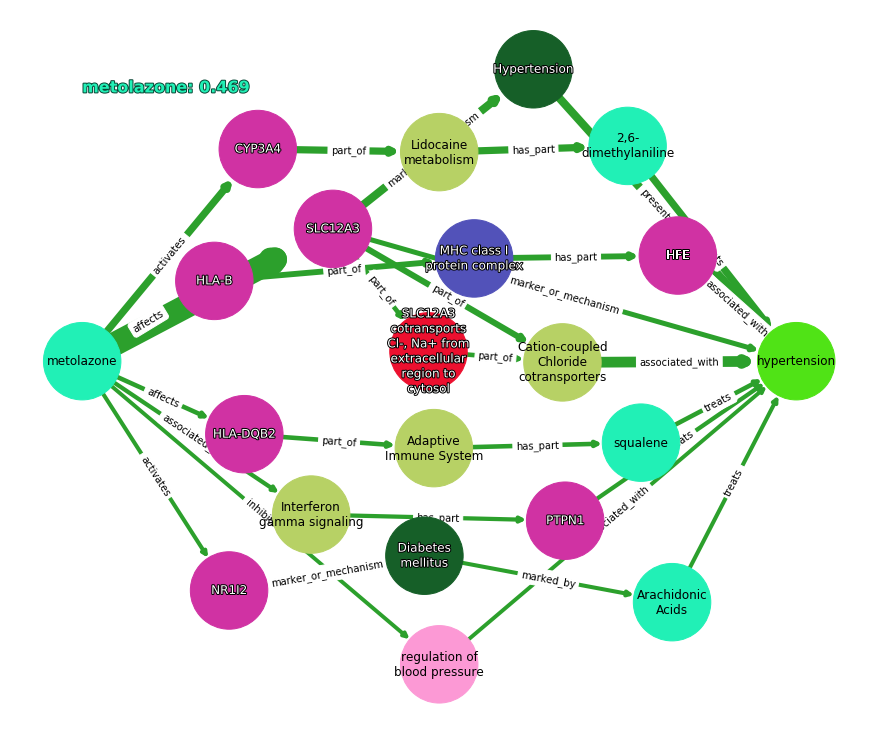

In [69]:
graph_overall_pair(6, 10)

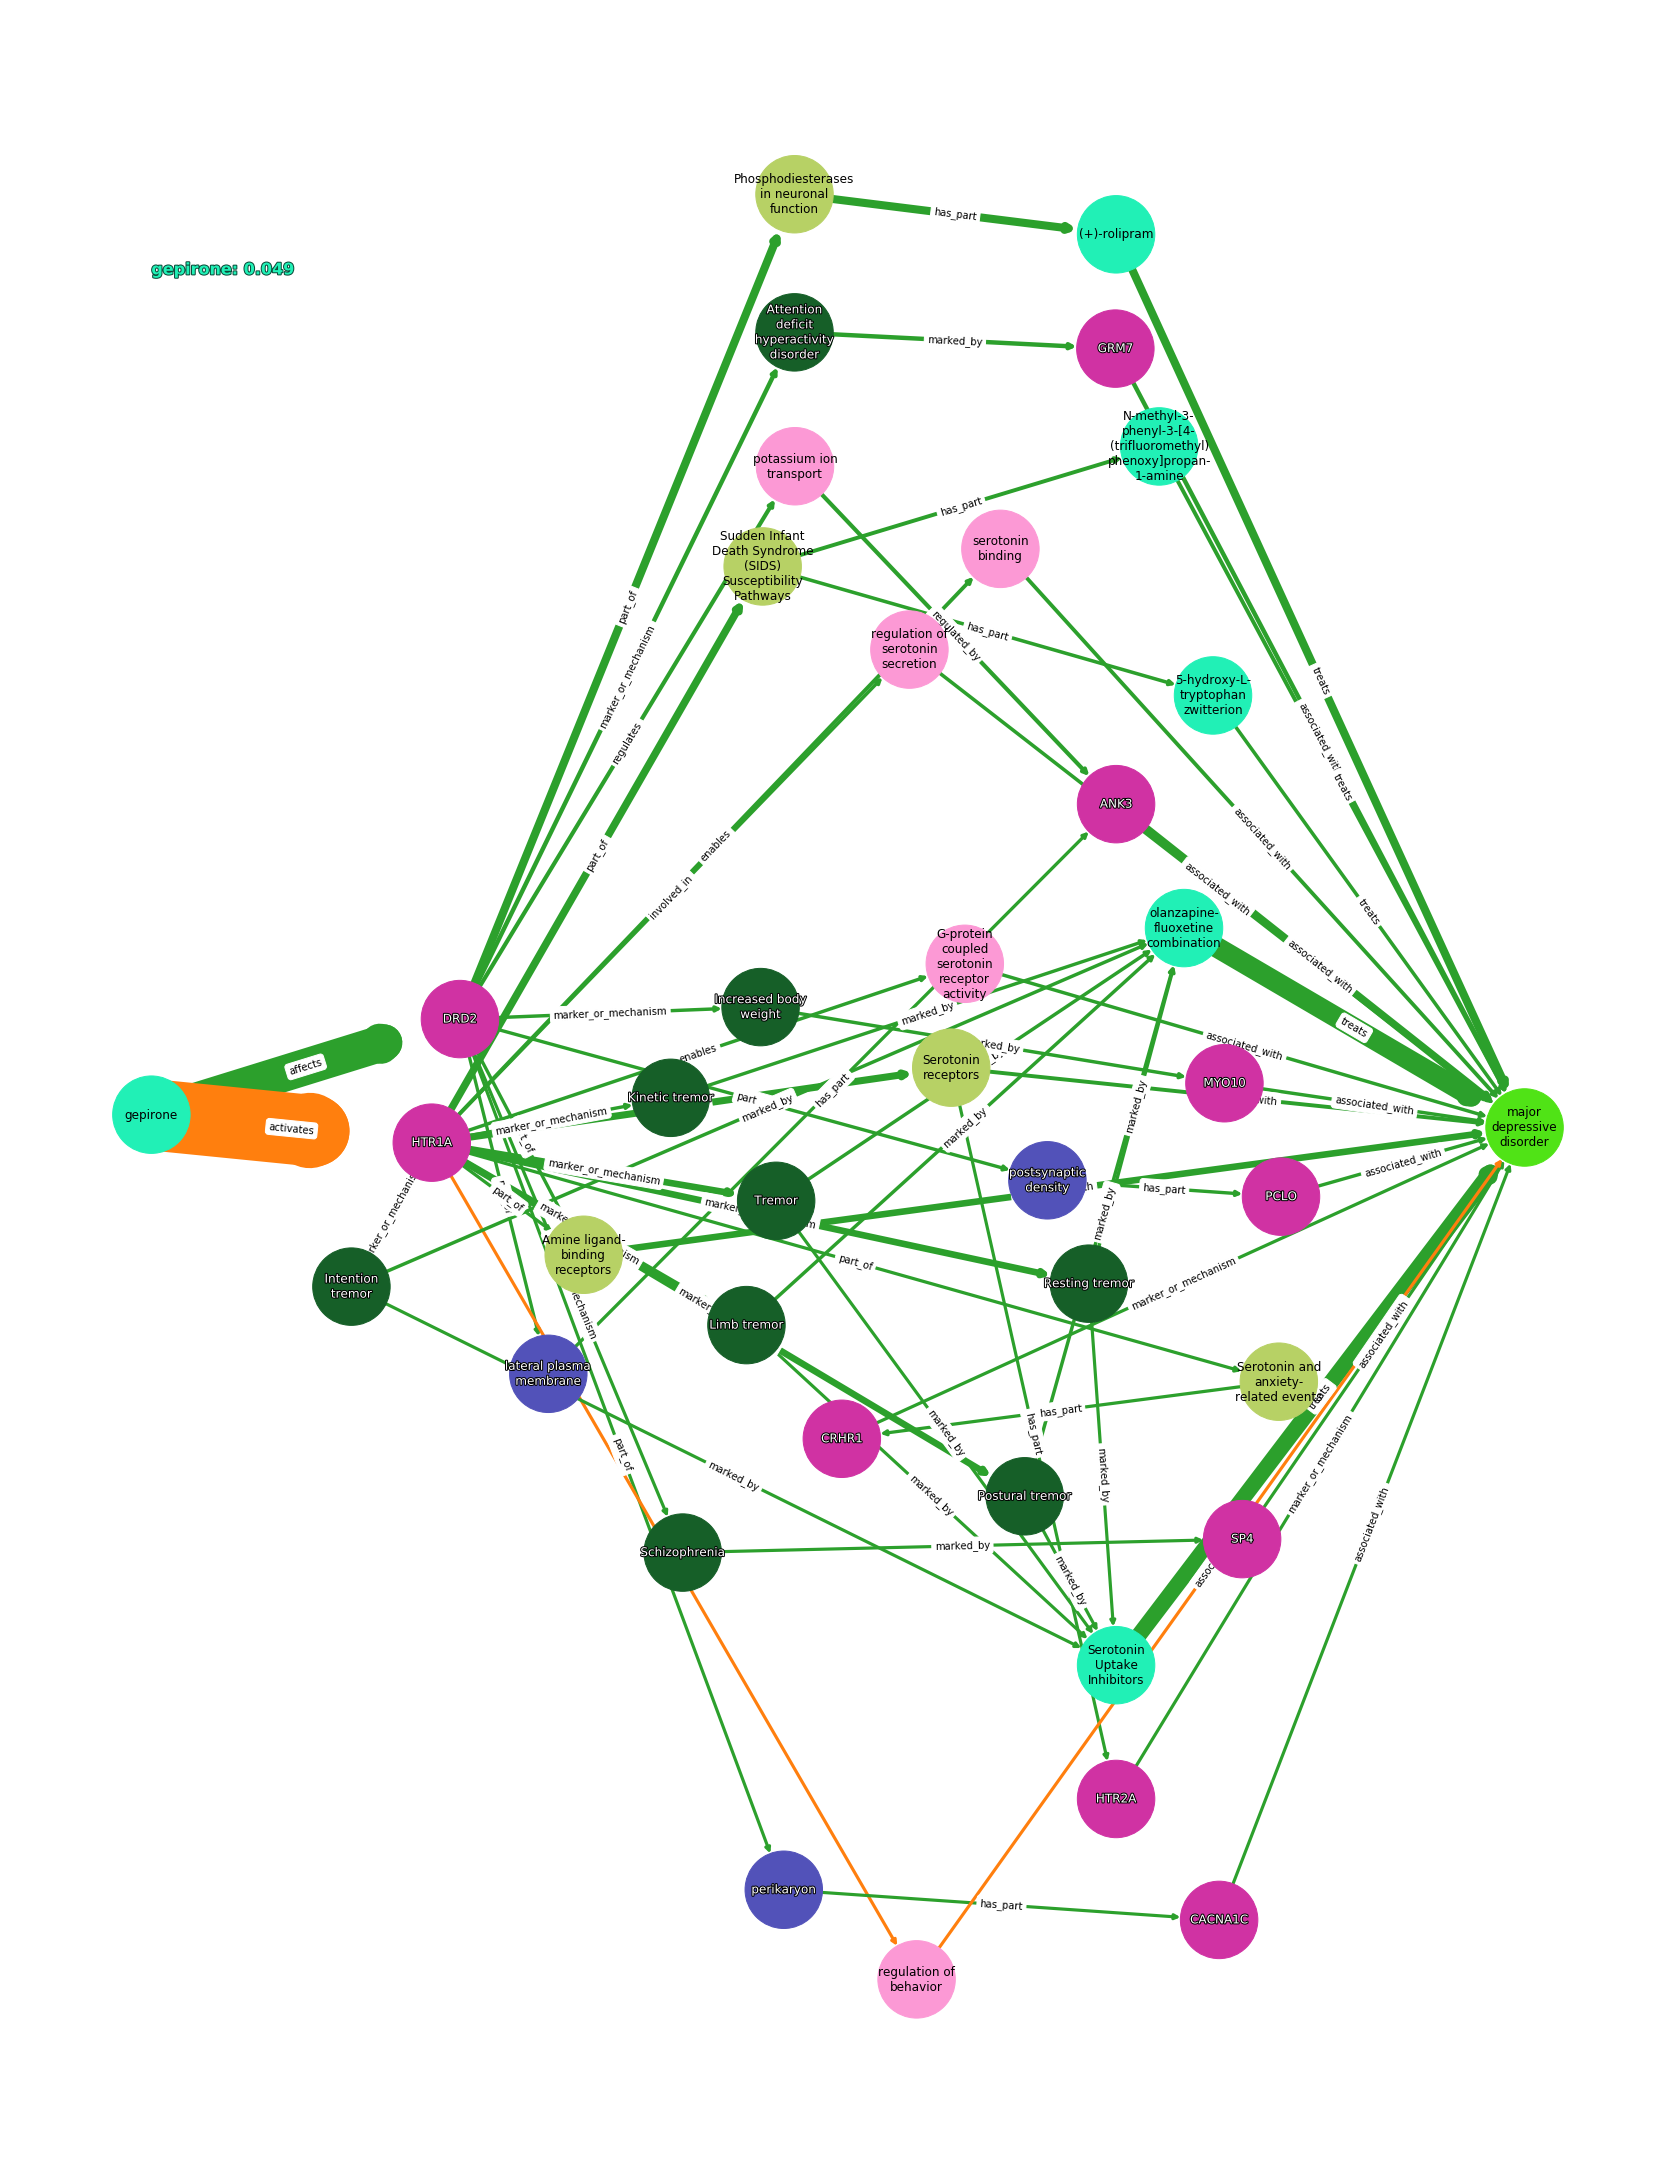

In [70]:
graph_overall_pair(7, 30)

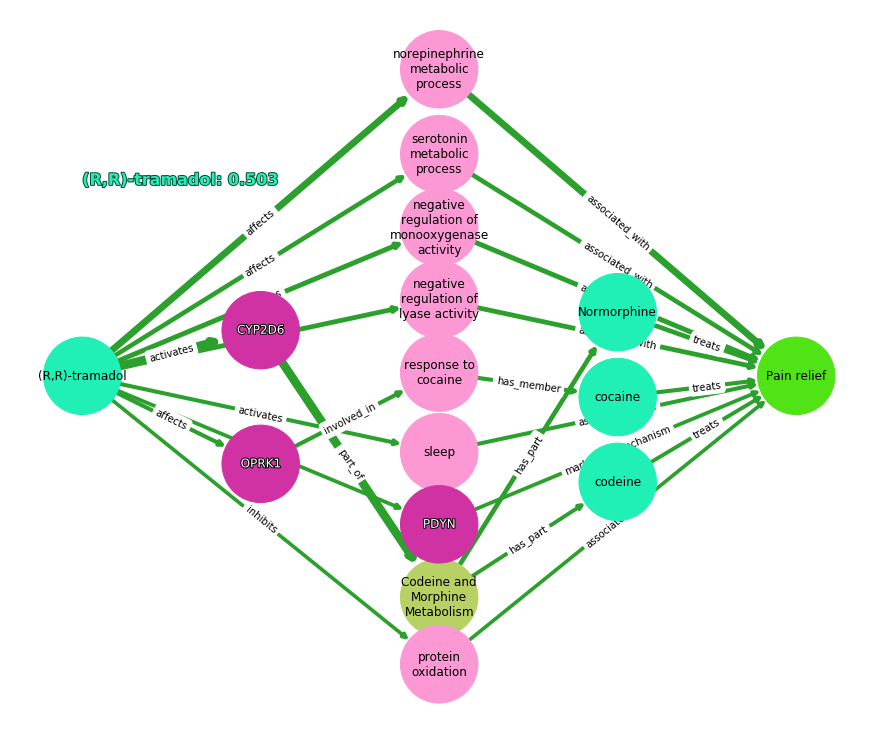

In [71]:
graph_overall_pair(8, 10)

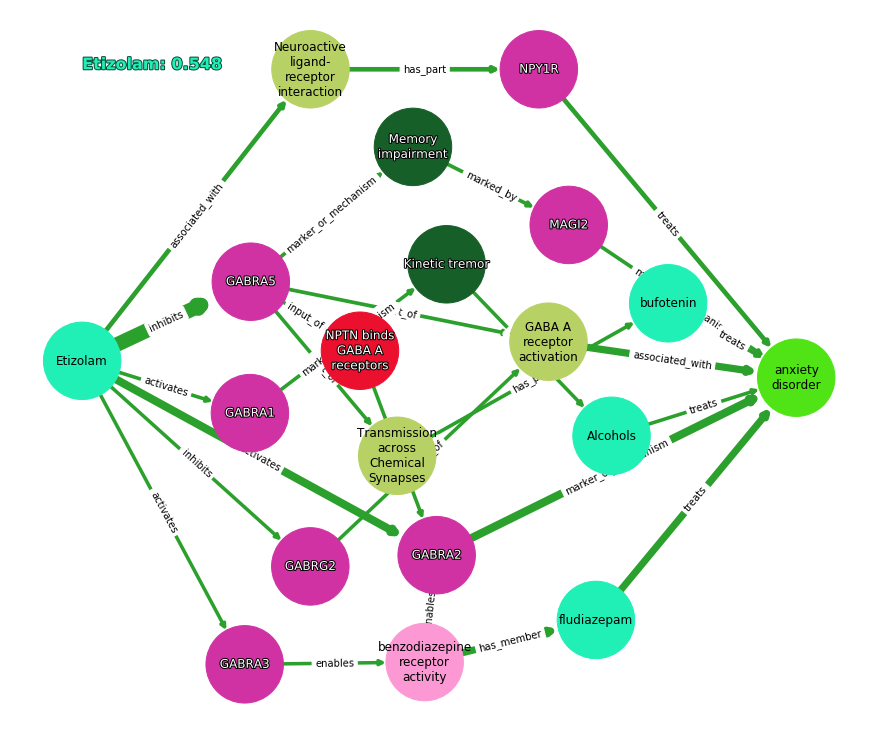

In [72]:
graph_overall_pair(9, 10)

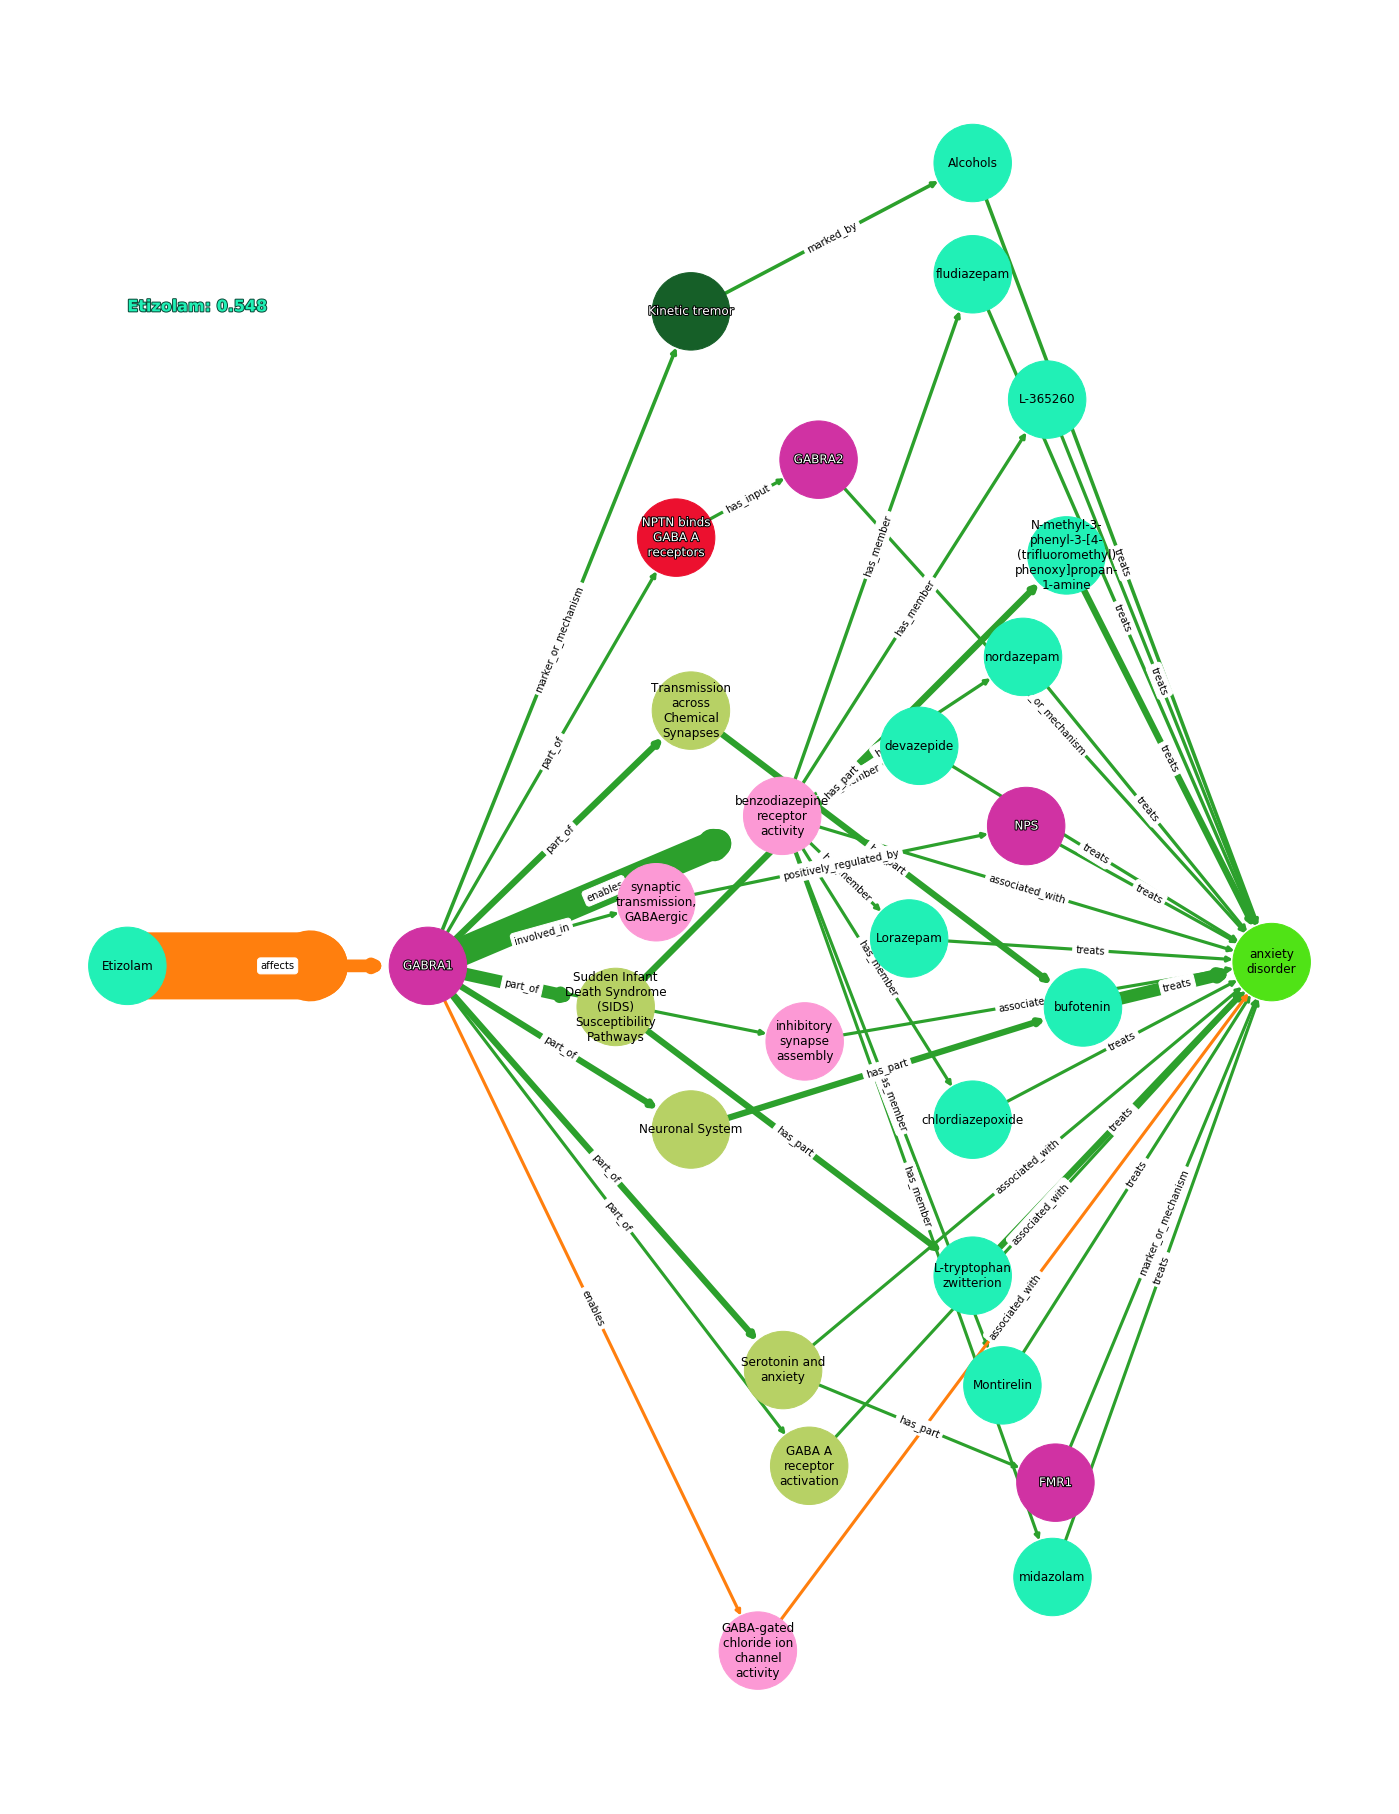

In [73]:
graph_tgt_pair(9, 25)

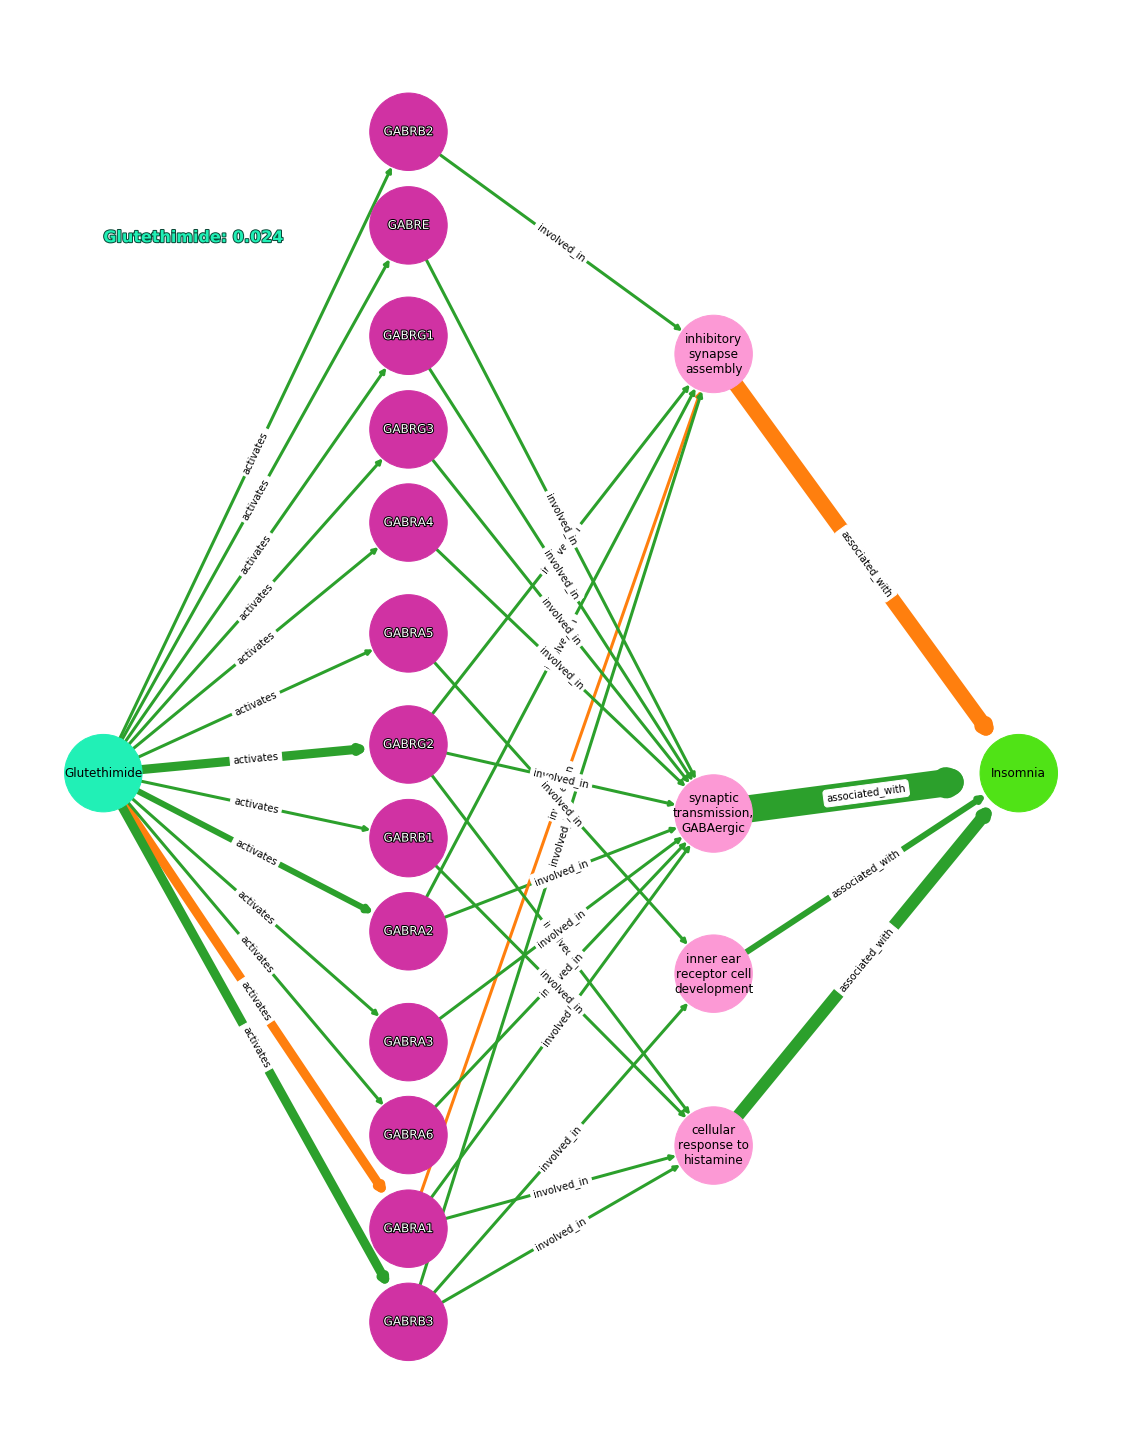

In [74]:
graph_mp_pair(10, 20)

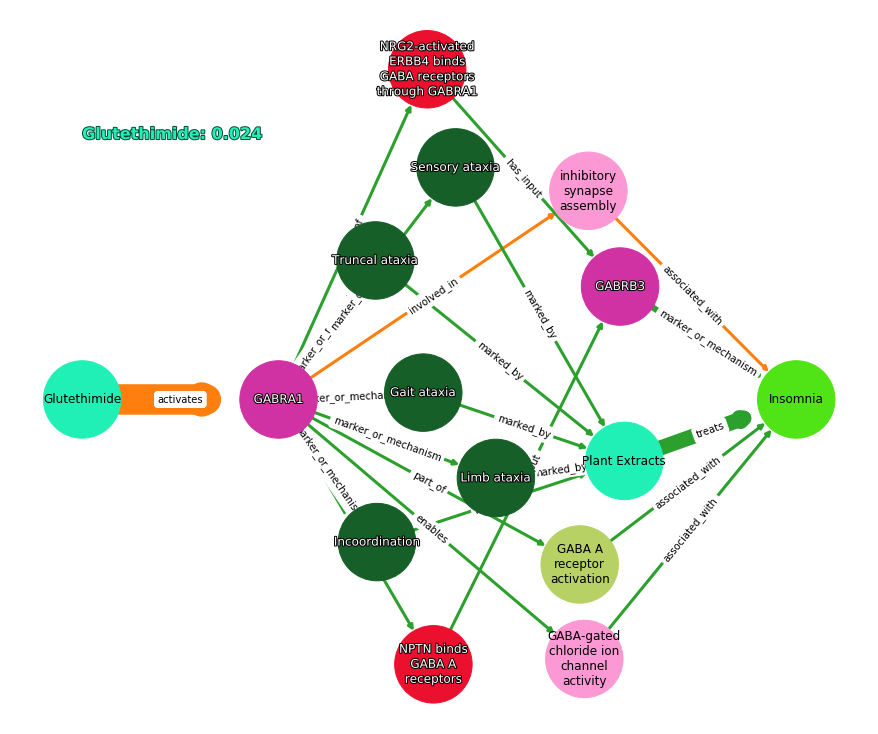

In [75]:
graph_tgt_pair(10, 10)

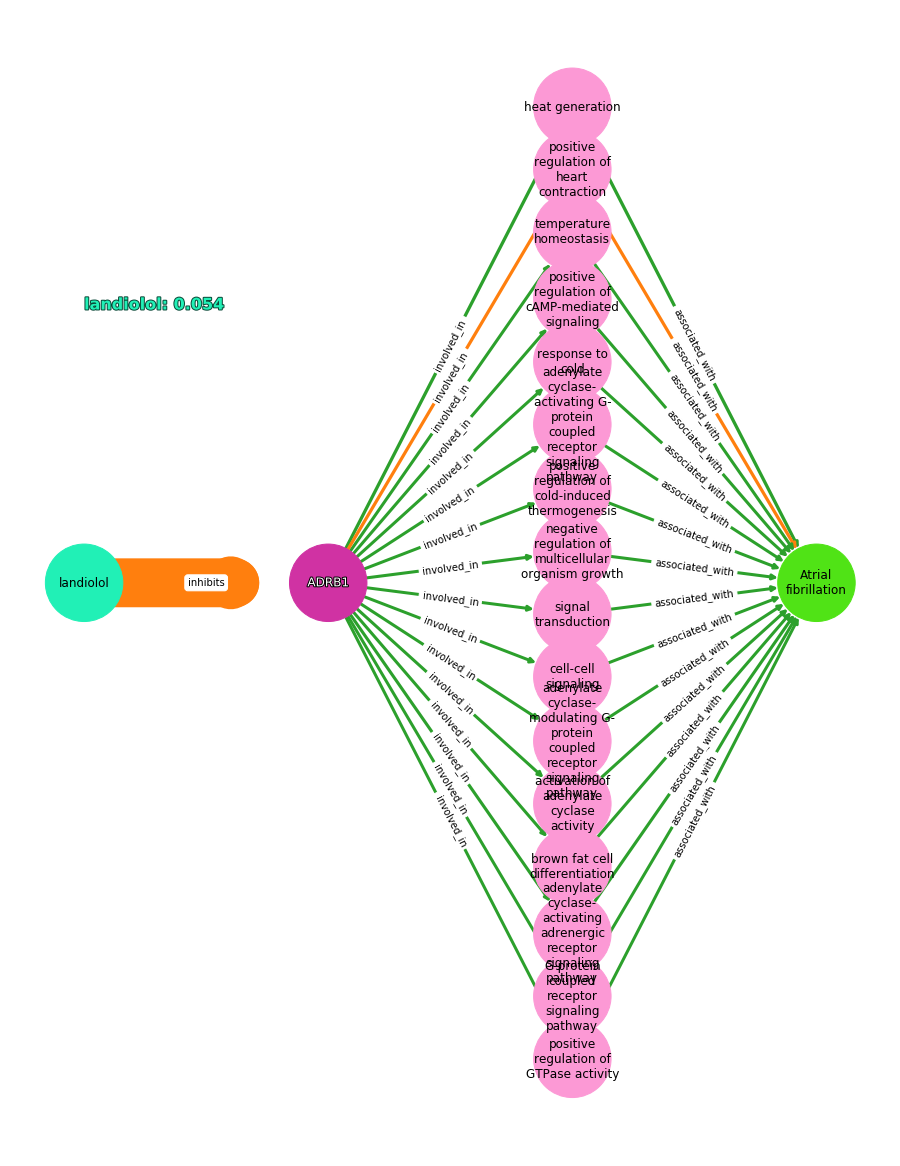

In [76]:
graph_mp_pair(5, 20)

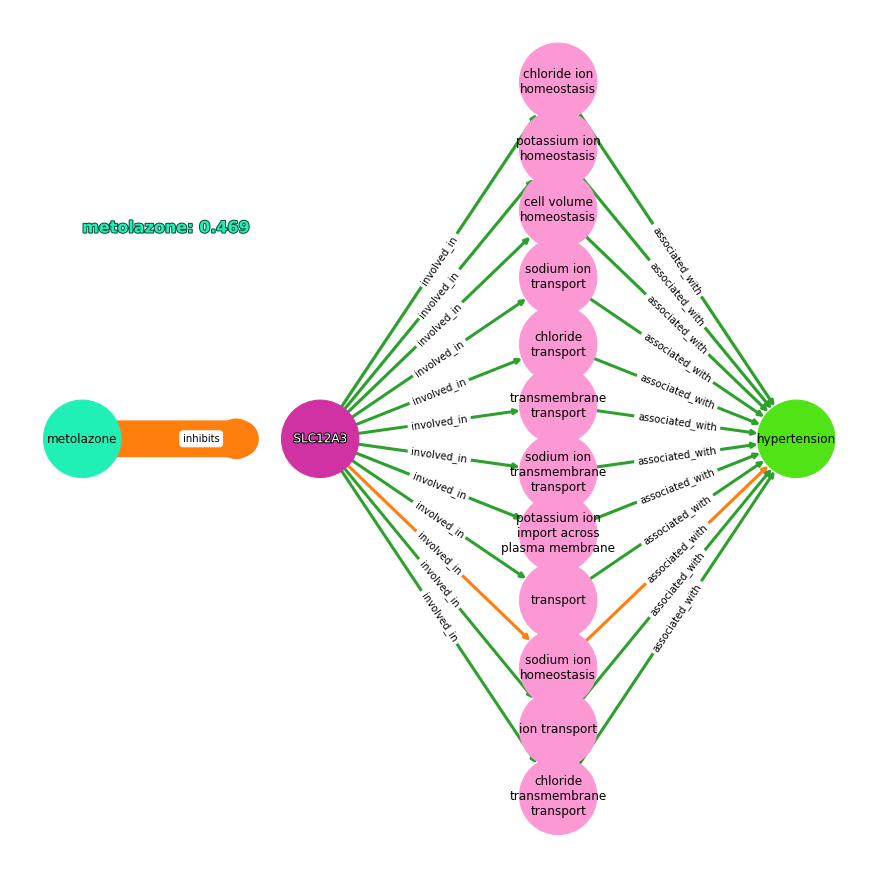

In [77]:
graph_mp_pair(6, 20)

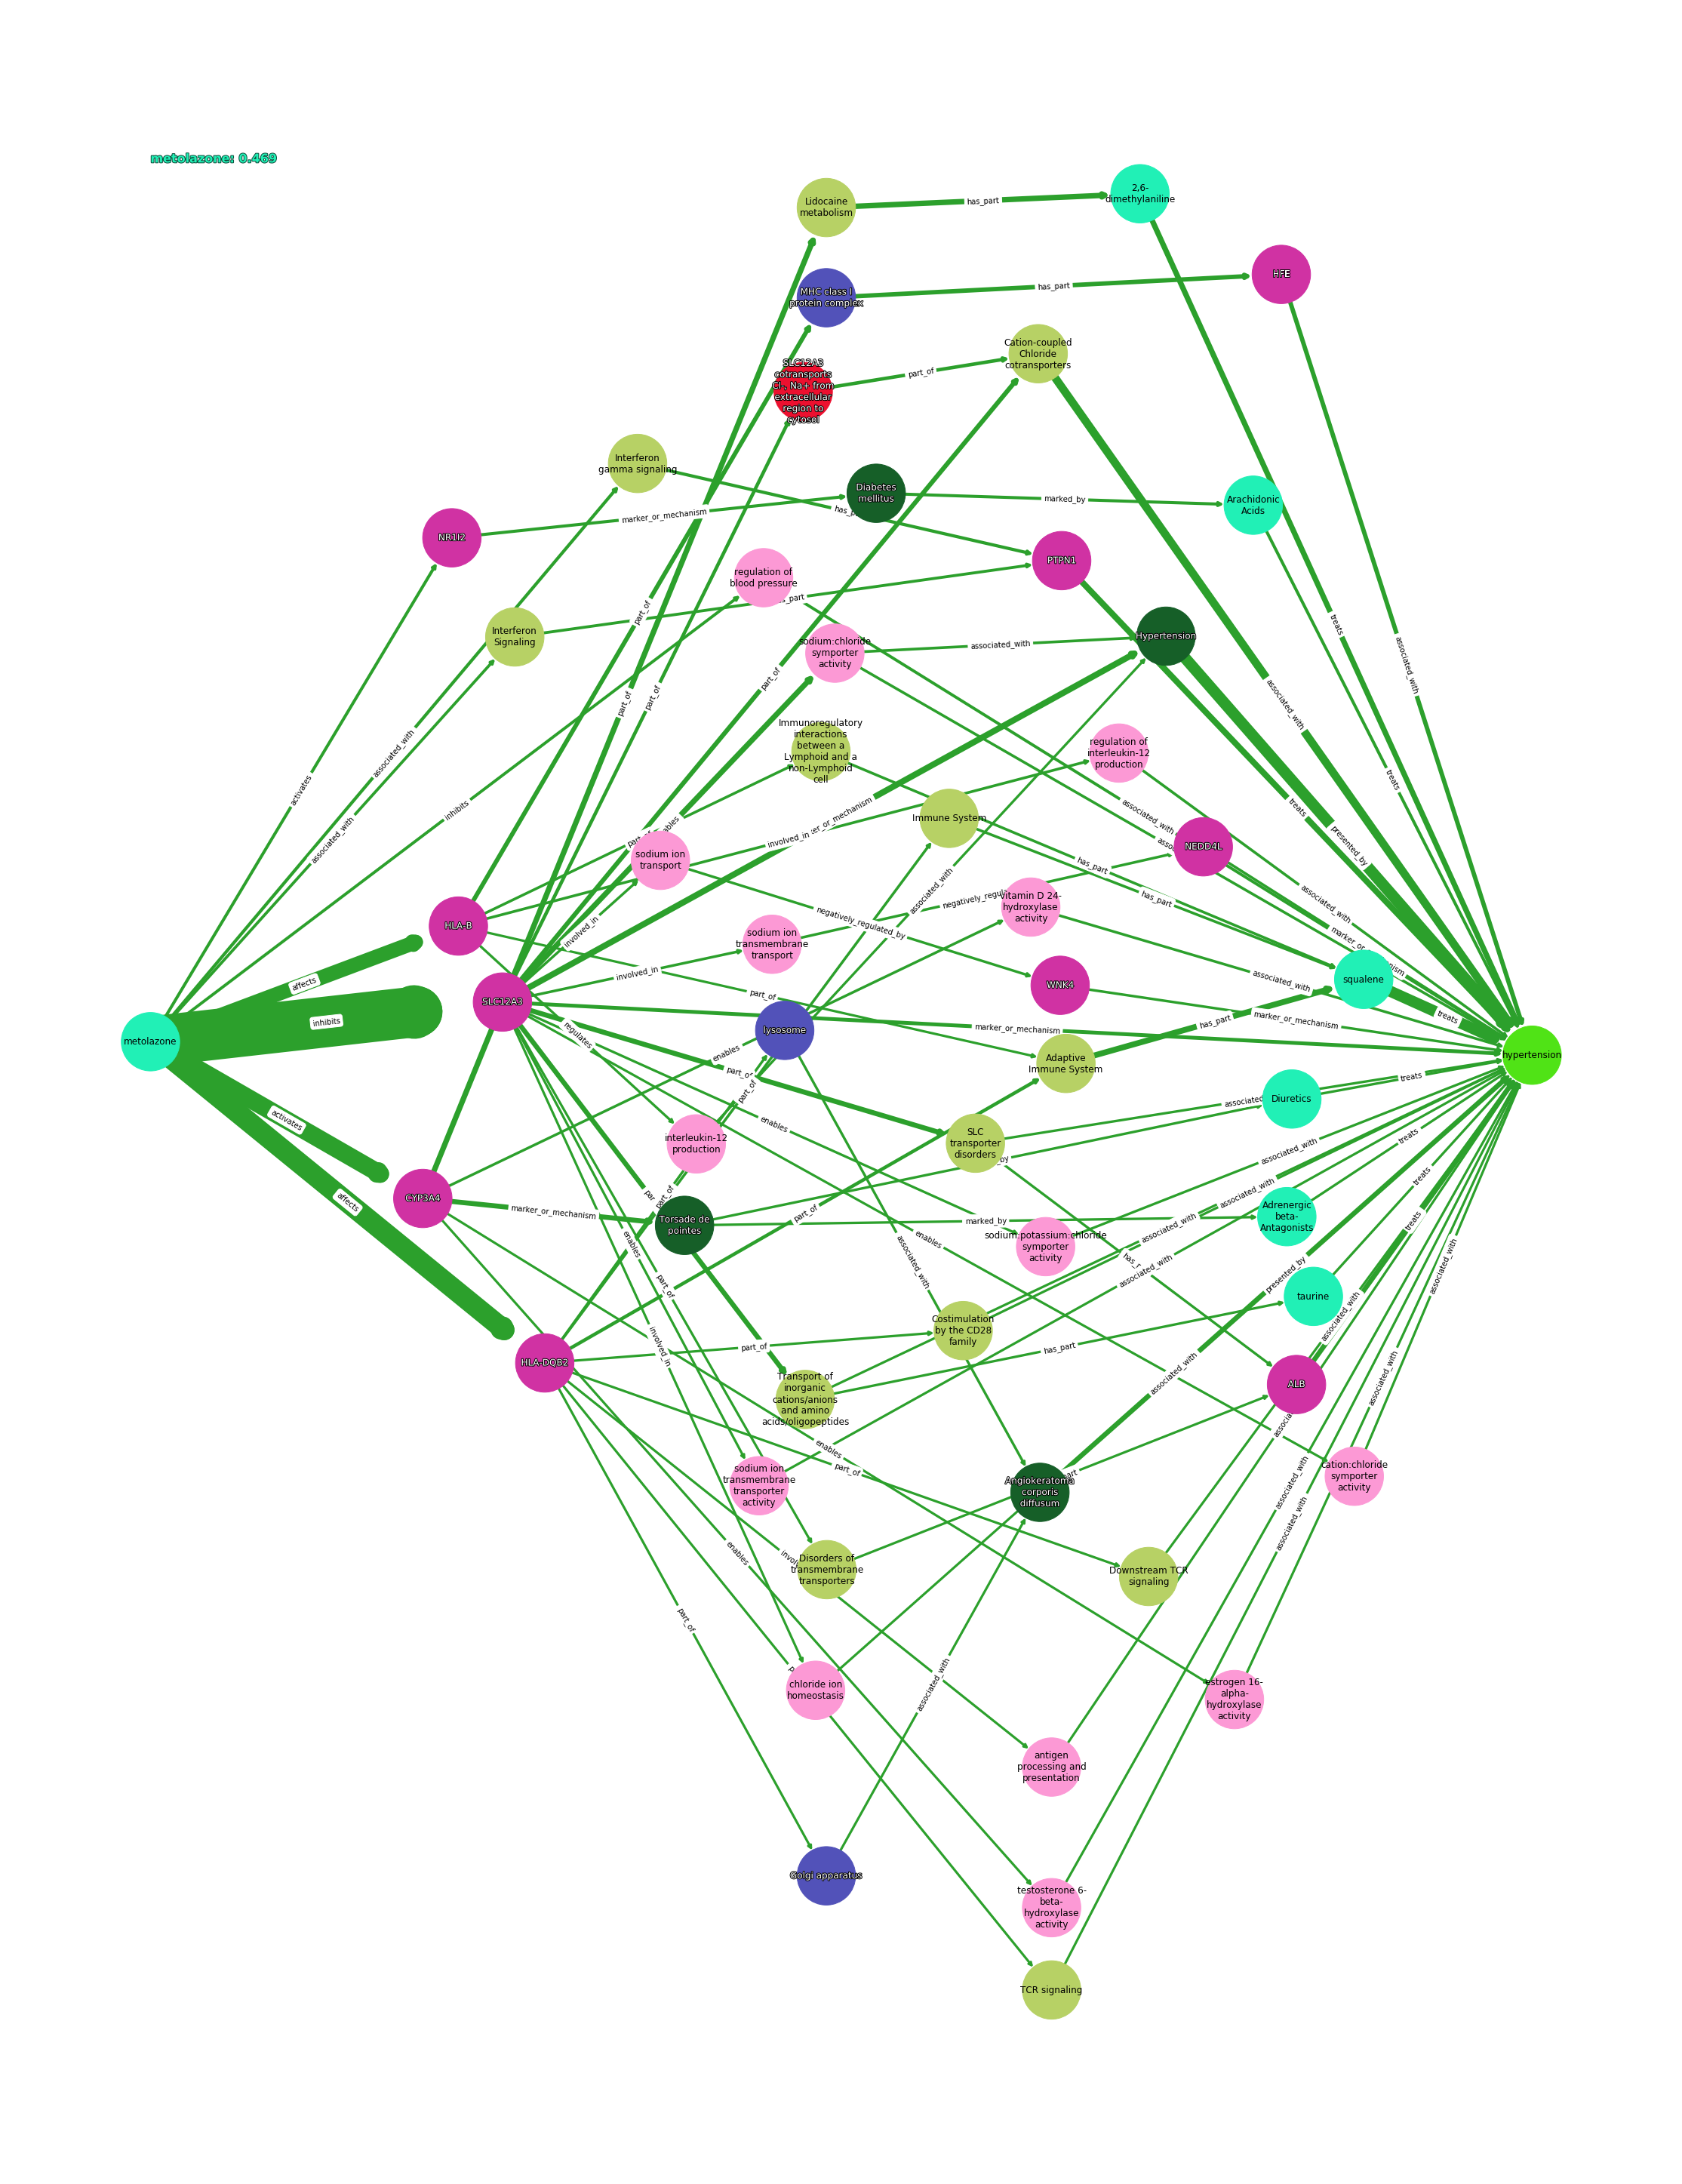

In [78]:
graph_overall_pair(6, 40)